# Рекомендация цифровой музыки

<b>Цель.</b> Настало время поработать с данными самой большой и самой дорогой компании, занимающейся, похоже, уже всем на свете: от продажи всего и вся, до настройки облачных инфраструктур и создания роботов. Конечно же это компания Джеффа могу-купить-весь-мир Безоса - Amazon.

<b>Описание/Пошаговая инструкция выполнения домашнего задания:</b>
</br>1. Выберите любой понравившийся вам набор данных по ссылке https://nijianmo.github.io/amazon/index.html, стоит обратить внимание на раздел "Small" subsets for experimentation, где представлены не самые большие датасеты (чтобы и в память поместился, и считался недолго).
</br>2. Проведите базовый EDA - распределения рейтингов, количество уникальных товаров и т.д.
</br>3. Сделайте разбиение данных на train и test методом leave-one-out.
</br>4. На основании вашего датасета постройте 2-3 рекомендательных модели, можно включить простой бейзлайн типа модели, рекомендующей самые популярные товары.
</br>5. Оцените качество полученных рекомендаций по метрикам HR@10, MRR@10, NDCG@10, coverage.
</br>6. Сделайте выводы о качестве моделей.

# Выполнение

<b>Подготовка данных</b>

Сначала импортируем необходимые библиотеки и загрузим датасет.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

In [2]:
import warnings

# Скрыть все предупреждения
warnings.filterwarnings('ignore')

Загрузка данных.

In [3]:
df = pd.read_csv('Digital_Music.csv')

# Базовый EDA

Первые 5 строк датасета.

In [4]:
df.head()

,asin,reviewerID,overall,unixReviewTime
0,0001388703,A1ZCPG3D3HGRSS,5.0,1387670400
1,0001388703,AC2PL52NKPL29,5.0,1378857600
2,0001388703,A1SUZXBDZSDQ3A,5.0,1362182400
3,0001388703,A3A0W7FZXM0IZW,5.0,1354406400
4,0001388703,A12R54MKO17TW0,5.0,1325894400


Общая информация о датасете.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584082 entries, 0 to 1584081
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   asin            1584082 non-null  object 
 1   reviewerID      1584082 non-null  object 
 2   overall         1584082 non-null  float64
 3   unixReviewTime  1584082 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 48.3+ MB


Описание числовых столбцов.

In [6]:
df.describe()

,overall,unixReviewTime
count,1.584082e+06,1.584082e+06
mean,4.660555e+00,1.408211e+09
std,8.440314e-01,7.857646e+07
min,1.000000e+00,8.773056e+08
25%,5.000000e+00,1.374883e+09
50%,5.000000e+00,1.420070e+09
75%,5.000000e+00,1.457222e+09
max,5.000000e+00,1.538438e+09


In [7]:
print("\nКоличество уникальных товаров (asin):", df['asin'].nunique())
print("Количество уникальных пользователей (reviewerID):", df['reviewerID'].nunique())


Количество уникальных товаров (asin): 456992
Количество уникальных пользователей (reviewerID): 840372


In [8]:
# Подсчет количества отзывов для каждого пользователя и товара
user_counts = df['reviewerID'].value_counts()
item_counts = df['asin'].value_counts()

# Выбор 10000 самых активных пользователей и 10000 самых популярных товаров
top_users = user_counts.head(10000).index
top_items = item_counts.head(10000).index

# Фильтрация датасета для оставления только выбранных пользователей и товаров
filtered_df = df[df['reviewerID'].isin(top_users) & df['asin'].isin(top_items)]

print("Размер исходного датасета:", df.shape)
print("Размер уменьшенного датасета:", filtered_df.shape)
print("Количество уникальных пользователей в уменьшенном датасете:", filtered_df['reviewerID'].nunique())
print("Количество уникальных товаров в уменьшенном датасете:", filtered_df['asin'].nunique())

Размер исходного датасета: (1584082, 4)
Размер уменьшенного датасета: (99002, 4)
Количество уникальных пользователей в уменьшенном датасете: 9211
Количество уникальных товаров в уменьшенном датасете: 9188


Распределение рейтингов.

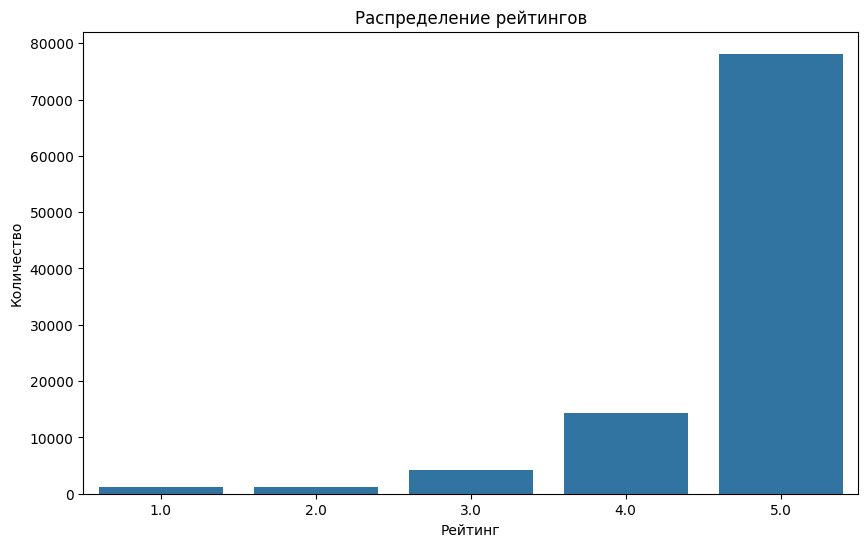

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x='overall', data=filtered_df)
plt.title('Распределение рейтингов')
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.show()

Распределение временных меток (год).

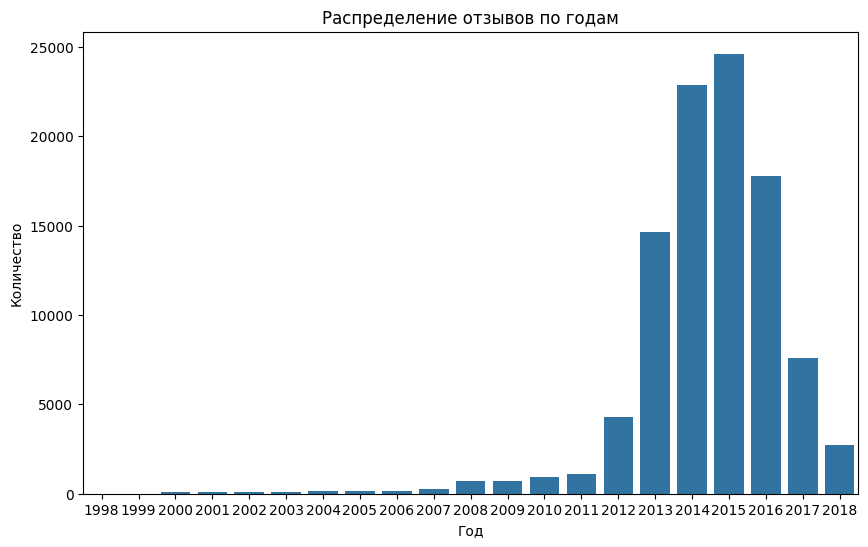

In [10]:
filtered_df['year'] = pd.to_datetime(filtered_df['unixReviewTime'], unit='s').dt.year
plt.figure(figsize=(10, 6))
sns.countplot(x='year', data=filtered_df)
plt.title('Распределение отзывов по годам')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.show()

# Разбиение данных на train и test методом leave-one-out

In [11]:
# Для каждого пользователя оставляем один отзыв в качестве теста
def leave_one_out_split(filtered_df, user_col='reviewerID', item_col='asin'):
    test_indices = filtered_df.groupby(user_col, group_keys=False).apply(lambda x: x.sample(1)).index
    train = filtered_df.drop(test_indices)
    test = filtered_df.loc[test_indices]
    return train, test

train, test = leave_one_out_split(filtered_df)

# Убедимся, что все пользователи из теста есть в тренировочном наборе
test = test[test['reviewerID'].isin(train['reviewerID'])]

print("Размер train датасета:", train.shape)
print("Размер test датасета:", test.shape)

Размер train датасета: (89791, 5)
Размер test датасета: (8637, 5)


# Построение рекомендательных моделей

Модель 1: Рекомендация популярных товаров.

In [12]:
class PopularityRecommender:
    def fit(self, train):
        self.popularity = train['asin'].value_counts().index.tolist()
        
    def recommend(self, user, N=10):
        return self.popularity[:N]

pop_rec = PopularityRecommender()
pop_rec.fit(train)

Модель 2: Коллаборативная фильтрация (Item-Item).

In [13]:
# Удаление дубликатов путем усреднения оценок
train = train.groupby(['reviewerID', 'asin']).agg({'overall': 'mean'}).reset_index()

print("Размер train датасета после удаления дубликатов:", train.shape)

# Обучение рекомендательной модели
class ItemItemRecommender:
    def fit(self, train):
        user_item_matrix = train.pivot(index='reviewerID', columns='asin', values='overall').fillna(0)
        self.user_item_matrix_sparse = csr_matrix(user_item_matrix.values)
        self.item_similarity = cosine_similarity(self.user_item_matrix_sparse.T)
        self.items = user_item_matrix.columns
        self.user_item_matrix = user_item_matrix
        
    def recommend(self, user, N=10):
        user_ratings = self.user_item_matrix.loc[user]
        scores = user_ratings.values @ self.item_similarity
        scores = pd.Series(scores, index=self.items)
        scores = scores[user_ratings == 0]
        return scores.nlargest(N).index.tolist()

ii_rec = ItemItemRecommender()
ii_rec.fit(train)

Размер train датасета после удаления дубликатов: (76743, 3)


# Оценка качества рекомендаций

In [14]:
# Функция для оценки метрик
def hit_rate(recommended, relevant):
    return int(relevant in recommended)

def reciprocal_rank(recommended, relevant):
    if relevant in recommended:
        return 1 / (recommended.index(relevant) + 1)
    return 0

def ndcg(recommended, relevant):
    if relevant in recommended:
        rank = recommended.index(relevant) + 1
        return 1 / np.log2(rank + 1)
    return 0

def coverage(recommender, users, items, N=10):
    recommended_items = set()
    for user in users:
        recommended_items.update(recommender.recommend(user, N))
    return len(recommended_items) / len(items)

def evaluate(recommender, train, test, N=10):
    hr, rr, ndcg_score = 0, 0, 0
    for _, row in test.iterrows():
        user = row['reviewerID']
        relevant = row['asin']
        recommended = recommender.recommend(user, N)
        hr += hit_rate(recommended, relevant)
        rr += reciprocal_rank(recommended, relevant)
        ndcg_score += ndcg(recommended, relevant)
    hr /= len(test)
    rr /= len(test)
    ndcg_score /= len(test)
    cov = coverage(recommender, train['reviewerID'].unique(), train['asin'].unique(), N)
    return hr, rr, ndcg_score, cov

# Оценка качества
pop_metrics = evaluate(pop_rec, train, test)
ii_metrics = evaluate(ii_rec, train, test)

# Вывод результатов
metrics_df = pd.DataFrame([pop_metrics, ii_metrics], columns=['HR@10', 'MRR@10', 'NDCG@10', 'Coverage'], index=['Popularity', 'Item-Item CF'])
print(metrics_df)

                 HR@10    MRR@10   NDCG@10  Coverage
Popularity    0.017251  0.007769  0.009962  0.001106
Item-Item CF  0.072363  0.038452  0.046358  0.933835


<b>Вывод.</b>

<b>Модель популярности:</b>
* Рекомендует ограниченное количество самых популярных товаров.
* Показатели HR, MRR и NDCG низкие, что указывает на слабую релевантность и качество рекомендаций.
* Очень низкое покрытие указывает на отсутствие разнообразия в рекомендациях.

<b>Item-Item Collaborative Filtering:<b>
* Значительно лучше справляется с рекомендацией релевантных товаров.
* Высокие показатели HR, MRR и NDCG указывают на лучшую релевантность и качество рекомендаций.
* Высокое покрытие показывает, что модель предоставляет разнообразные рекомендации, охватывая практически весь ассортимент доступных товаров.

<b>Таким образом, модель Item-Item CF явно превосходит модель популярности по всем метрикам, предоставляя более релевантные и разнообразные рекомендации.<b>